# Assignment 1

In [1]:
#!pip install sklearn
# !pip install pandas
# !pip install numpy
# !pip install scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
# create a function to plot cost
def plot_cost(loss):
    plt.figure()
    plt.plot(np.arange(len(loss)), loss)
    plt.xlabel("epochs")
    plt.ylabel("cost")
    plt.show()

### Implement the backpropagation algorithm for multiple classes

In [4]:
#read data from file
df = pd.read_csv('wine_quality_white_modified.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_class
0,0.478873,0.236364,0.253012,0.025836,0.141618,0.141869,0.277273,0.955745,0.908377,0.444444,0.739437,3
1,0.366197,0.140909,0.198795,0.024316,0.080925,0.044983,0.134091,0.952617,0.863874,0.777778,0.838028,3
2,0.556338,0.463636,0.204819,0.039514,0.141618,0.044983,0.306818,0.956082,0.808901,0.472222,0.704225,1
3,0.450704,0.254545,0.246988,0.103343,0.130058,0.211073,0.490909,0.957863,0.808901,0.425926,0.661972,1
4,0.485915,0.136364,0.168675,0.066869,0.083815,0.048443,0.243182,0.956197,0.848168,0.425926,0.732394,3


In [5]:
#convert data to numpy array
data = df.to_numpy()

#shuffle the data set
np.random.shuffle(data)


In [6]:
# seperate X and y
X = data[: , :11]
y = data[: , 11].astype(int)

#split data to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [7]:
# neural network class
class nueral_network(object):

    #initial function
    def __init__(self, X, Y, ginHidden):
        self.loss = []
        self.m = X.shape[0]

        self.Y = self.oneHotIt(Y)
        self.input = X
        self.output = np.zeros(self.Y.shape)

        self.inputsize = X.shape[1]
        self.outputsize = self.Y.shape[1]
        self.hiddensize = ginHidden
        
        self.W1 = np.random.uniform (-0.1, 0.1, (self.inputsize , self.hiddensize))
        self.W2 = np.random.uniform (-0.1, 0.1, (self.hiddensize , self.outputsize))

        self.b1 = np.zeros((1 , self.hiddensize))
        self.b2 = np.zeros((1 , self.outputsize))


    def oneHotIt(self , y):
        OHX = scipy.sparse.csr_matrix((np.ones(self.m), (y , np.array(range(self.m)))))
        OHX = np.array(OHX.todense()).T
        return OHX
    
    def adapt_learning_rate(self, loss, max_iter, epochCounter,  maxLR = 0.2, minLR = 0.005):  
        average_loss = np.round(np.mean(self.loss)  if (len(self.loss) < 4) else np.mean(self.loss[-3:]) ,5)      
        current_loss = np.round(loss,5)  
         
        if average_loss >= current_loss :  
            alpha  =   min(maxLR , self.lr)
        else:  
            beta = 0.3
            self.lr -= beta * self.lr 
            

    def softmax(self,z):
        z -= np.max(z)
        sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
        return sm
    

    def tanh(self, x):
        t = (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))
        return t
    

    def dTanh(self,x):
        t = np.tanh(x)
        dt = 1 - t**2
        return dt
    

    def nloss(self):
        loss =  -np.mean(self.Y * np.log(self.output + 1e-8))
        return loss
    

    def forward(self,X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = np.tanh(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.output = self.softmax(self.Z2)
        return self.output
    

    def backward(self , i):
        d_output = self.output - self.Y  

        d_W2 = 1./ self.m * np.dot(self.A1.T , d_output)
        d_b2 = 1./ self.m * np.sum(d_output, axis=0, keepdims=True) 
        d_A1 = np.dot(d_output , self.W2.T)

        d_Z1 = d_A1 * self.dTanh(self.Z1)
        d_W1 = 1. / self.m * np.dot(self.input.T , d_Z1)
        d_b1 = 1. / self.m * np.sum(d_Z1, axis=0, keepdims=True)      

        self.W1 -=  self.lr * d_W1
        self.b1 -=  self.lr * d_b1
        self.W2 -=  self.lr * d_W2
        self.b2 -=  self.lr * d_b2

          
    def train(self, max_iter = 1000 , init_lr = 0.5):

        self.lr = init_lr
        for i in range(0, max_iter):
            self.output = self.forward(self.input)
            loss = self.nloss()
            self.loss.append(loss)
            self.adapt_learning_rate(loss , max_iter , i )
            self.backward(i)
            #if i % 100 == 0:
                #print ("Cost after iteration %i: %f by learning %f" %(i, loss , self.lr ))   
                

    def predict(self, X):
        probs = self.forward(X)
        r = np.argmax(probs ,axis=1)     
        return r

### Result with different configs

In [8]:
def run_nural_network (ginHidden , init_lr  , max_iter = 1000):
    network = nueral_network(X_train, y_train, ginHidden)
    network.train(max_iter  , init_lr )
    predict_train = network.predict(X_train)
    predict_test = network.predict(X_test)
    print("Number of hiddent units: %i, intitial learing rate: %f " % (ginHidden, init_lr))
    print("Accuracy Train Set :" , accuracy_score(y_train, predict_train) * 100)
    print("Accuracy Test Set :" , accuracy_score(y_test, predict_test) * 100)
    plot_cost(network.loss)

Number of hiddent units: 100, intitial learing rate: 0.500000 
Accuracy Train Set : 48.78472222222222
Accuracy Test Set : 48.61111111111111


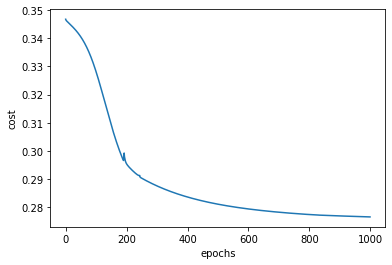

In [9]:
run_nural_network(ginHidden = 100, init_lr = 0.5 , max_iter = 1000 )

Number of hiddent units: 50, intitial learing rate: 0.050000 
Accuracy Train Set : 45.13888888888889
Accuracy Test Set : 38.19444444444444


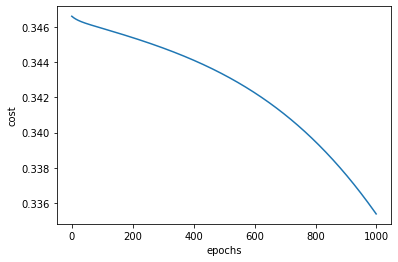

In [10]:
run_nural_network(ginHidden = 50, init_lr = 0.05 , max_iter = 1000 )

Number of hiddent units: 50, intitial learing rate: 0.005000 
Accuracy Train Set : 32.46527777777778
Accuracy Test Set : 27.77777777777778


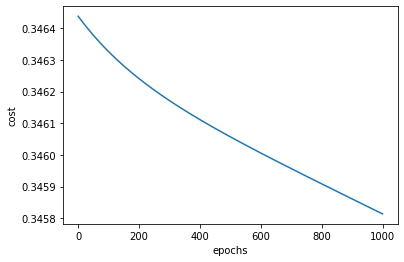

In [11]:
run_nural_network(ginHidden = 50, init_lr = 0.005 , max_iter = 1000 )

In [12]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='adam',learning_rate_init=0.0005, learning_rate='adaptive' ,activation='tanh' ,max_iter=1000,random_state=42)
mlp.fit(X_train,y_train)


p_train = mlp.predict(X_train)
p_test = mlp.predict(X_test)

print("Accuracy train set:" , accuracy_score(y_train, p_train) * 100)
print("Accuracy Test set:" , accuracy_score(y_test, p_test) * 100)


Accuracy train set: 50.34722222222222
Accuracy Test set: 47.91666666666667


### Using the GridSearchCV to find fit value for parameter of MLPClassifier library

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'max_iter': [1000 , 2000], 
              'activation' : ['tanh','relu'],              
              'learning_rate_init':[0.0005, 0.005 , 0.1 , 0.2], 
              'random_state':[9,10,11,12,13,14]}

clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)
clf.fit(X_train, y_train)
print("Optimized Parameters: ",clf.best_params_)

result_test = clf.predict(X_test)
result_train = clf.predict(X_train)
print("Accuracy on Train set:" , clf.score(X_train, result_train))
print("Accuracy on Test set:" ,  clf.score(y_test, result_test))